# 3D imaging processing for Tingyun

---

**Author**: Elephes The Martian  
**E-mail**: [eu23@ic.ac.uk](mailto:eu23@ic.ac.uk)  
**Affiliation**: DoLS, Imperial College
**Address**: 3F, Sir Ernst Chain Building, South Kensington, London SW7 2AZ  

---

📅 *Last updated: 28/07/2025*  
🔬 *Notebook for biological image analysis-Time_Lapse_Imaging*


<div style="background-color:#172A4A; color:white; padding:12px; border-radius:8px; font-size:18px; font-weight:bold;">
    <span style="font-size:22px;"> Importing Packages/Libraries</span><br>
</div>

In [8]:
import json
import os
import pickle
import textwrap
from glob import glob

from colorama import Fore, Style, init as colorama_init
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from joblib import Parallel, delayed

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from matplotlib.patches import Rectangle
import seaborn as sns
from IPython.display import FileLink, HTML, display
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from ipywidgets import IntSlider, Dropdown
from ipywidgets import IntSlider, Dropdown, HBox, VBox
from ipywidgets import interactive_output
import textwrap

import aicspylibczi
import pims
import tifffile
from czifile import CziFile

import skimage as ski
from skimage import color, exposure, filters, measure, morphology
from skimage.color import label2rgb
from skimage.exposure import adjust_gamma, equalize_adapthist, match_histograms
from skimage.filters import threshold_otsu
from skimage.io import imsave
from skimage.measure import label, regionprops
from skimage.morphology import dilation, disk, remove_small_objects
from skimage.transform import resize

from cellpose import io, models
import btrack
from btrack.btypes import PyTrackObject
import trackpy as tp

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

import napari

colorama_init()

<div style="background-color:#172A4A; color:white; padding:12px; border-radius:8px; font-size:18px; font-weight:bold;">
    <span style="font-size:22px;">📊 Plotting Control Panel</span><br>
    <span style="font-size:15px; font-weight:normal;">Use this panel to adjust plotting parameters and visualisation options.</span>
</div>

In [3]:
plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the foflags.N of axes labels
        "savefig.format": "pdf",  # how figures should be saved
        "legend.edgecolor": "0.0",
        "legend.framealpha": 1.0,
    }
)

# $\Alpha$. Import and Background Correction

## $\alpha-1.$ Import the imaging file as Numpy array
 ```scikit-image```

 <img src="https://scikit-image.org/_static/img/logo.png" alt="Alt text" width="100">

In [5]:
folder_path = "./"

In [39]:
'''🫡Define your folder path here'''
folder_path = "./"

# Gather all CZI and TIF/TIFF files, sorted by name
file_exts = [".czi", ".tif", ".tiff"]
raw_files = sorted([
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if any(f.lower().endswith(ext) for ext in file_exts)
])

if not raw_files:
    raise FileNotFoundError(f"No .czi or .tif/.tiff files found in {folder_path}")

ioi_files = {}
ioi_files_name = {}

for idx, file_path in tqdm(enumerate(raw_files), desc="Files in the folder", total=len(raw_files)):
    image_key = f"ioi_{idx}" 
    ext = os.path.splitext(file_path)[-1].lower()
    if ext == ".czi":
        czi = CziFile(file_path)
        data, _ = czi.read_image()
        frame = np.squeeze(data)
    elif ext in [".tif", ".tiff"]:
        frame = tifffile.imread(file_path)
    else:
        continue  # skip unhandled file types

    ioi_files[idx] = frame
    ioi_files_name[idx] = os.path.basename(file_path)
    globals()[image_key] = frame  
    print(f"Loaded {image_key} - Shape: {frame.shape}, File Name: {ioi_files_name[idx]}")

print(f"Imported {len(ioi_files)} image files (.czi and .tif/.tiff).")

Files in the folder:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded ioi_0 - Shape: (16, 38, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep3 laser=2 FOV1.tif
Loaded ioi_1 - Shape: (16, 34, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep3 laser=2 FOV2.tif
Loaded ioi_2 - Shape: (16, 39, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep3 laser=2 FOV3.tif
Loaded ioi_3 - Shape: (16, 47, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep4 laser=2 FOV1.tif
Loaded ioi_4 - Shape: (16, 43, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep4 laser=2 FOV2.tif
Loaded ioi_5 - Shape: (16, 43, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep4 laser=2 FOV3.tif
Loaded ioi_6 - Shape: (16, 36, 1024, 1024), File Name: 20250721 THP1 +CoC z step=0.5 1min x 15min Rep4 laser=2 FOV4.tif
Imported 7 image files (.czi and .tif/.tiff).


**Check the raw images**


 <img src="https://napari.org/dev/_static/logo.png" alt="Alt text" width="50">

In [14]:
file = 0

viewer = napari.Viewer()
viewer.add_image(ioi_files[file])

<Image layer 'Image' at 0xa863d6a90>

## $\alpha-2.$ Pre-processing

$\text{anisotropy} = \frac{\text{Z spacing}}{\text{XY spacing}}   \approx 1.72$

- **`ioi_files_resized`**: Raw 3D images that have been resized for faster visualisation.  

- **`ioi_processing`**: Raw 3D images that have only been pre-processed (not resized).  
  *Intended for downstream Cellpose segmentation*

In [ ]:
anisotropy = 1.72
print("anisotropy: ", anisotropy)

ioi_files_resized = {}
for i in tqdm(ioi_files, desc = 'files'):
    raw_image = ioi_files[i]
    t, z, y, x = raw_image.shape
    new_z = int(z * anisotropy)
    stack = np.empty((t, new_z, y, x), dtype=np.float32)
    for t_idx in tqdm(range(t), desc = 'frame', total=t, leave=False):
        volume = resize(
            raw_image[t_idx], (new_z, y, x),
            preserve_range=True)
        stack[t_idx] = volume
    ioi_files_resized[i] = stack

anisotropy:  1.72


**Check the re-sized images**

```ioi_files_resized```

 <img src="https://napari.org/dev/_static/logo.png" alt="Alt text" width="50">

In [19]:
file = 0
viewer = napari.Viewer()
viewer.add_image(ioi_files_resized[file], colormap='gist_earth')

<Image layer 'Image' at 0x3645c9190>

In [ ]:
ioi_processing = {}
for i in tqdm(ioi_files, desc='file'):
    raw_image = ioi_files[i]
    t, z, y, x = raw_image.shape
    # new_z = int(z * anisotropy)
    stack = np.empty((t, z, y, x), dtype=np.float32)
    for t_idx in tqdm(range(t), desc = 'frame', total=t, leave=False):
        volume = raw_image[t_idx]
        volume = gaussian_filter(volume, sigma=2) 
        low, high  = np.percentile(volume, (0.1, 99.5))
        # volume = np.clip((volume - low) / (high - low), 0, 1)
        volume = equalize_adapthist(
            volume,
            kernel_size=(max(1, z // 12), y // 24, x // 24),
            clip_limit=0.03,
            nbins=256
        )
        volume = adjust_gamma(volume, gamma = 2)
        stack[t_idx] = volume
    ioi_processing[i] = stack

**Check the re-sized images**

```ioi_processing```

 <img src="https://napari.org/dev/_static/logo.png" alt="Alt text" width="50">

In [21]:
file = 0
viewer = napari.Viewer()
viewer.add_image(ioi_processing[file], colormap='gist_earth')

<Image layer 'Image' at 0x5630fb8d0>

**You can save and re-load the ```ioi_processing``` here since it takes a bit to run pre-processing**

In [ ]:
file_name = "ioi_processing.pkl" 
file_path = os.path.join(folder_path, file_name) 
os.makedirs(folder_path, exist_ok=True)
with open(file_path, "wb") as file:
    pickle.dump(ioi_processing, file)
print(f"Dictionary saved successfully to {file_path}")

In [61]:
file_name = "ioi_processing.pkl"
file_path = os.path.join(folder_path, file_name)
with open(file_path, "rb") as file:
    ioi_processing = pickle.load(file)

print("Dictionary loaded successfully!")
print(type(ioi_processing))   # Should print <class 'dict'>
print(ioi_processing.keys())  # See what keys you have

Dictionary loaded successfully!
<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6])


# $\Beta$. Segmentation

**HPC runs the segmentation for us**

```cellpose```

<img src="https://camo.githubusercontent.com/87c40b9c361fcbc981a20f5dbc58b570882236c8699fe7d11d504a9092528b35/687474703a2f2f7777772e63656c6c706f73652e6f72672f7374617469632f696d616765732f6c6f676f2e706e673f7261773d54727565" alt="Alt text" width="100">

In [14]:
results_dir = os.path.join(folder_path, "masks")

mask_files = sorted(
    [f for f in os.listdir(results_dir) if f.startswith("mask_") and f.endswith(".pkl")],
    key=lambda x: int(x.split("_")[1].split(".")[0])
)

ioi_masks = {}

for fname in tqdm(mask_files):
    mask_key = int(fname.split("_")[1].split(".")[0])
    full_path = os.path.join(results_dir, fname)
    with open(full_path, "rb") as f:
        masks = pickle.load(f)
        ioi_masks[mask_key] = masks

print("Loaded keys:", list(ioi_masks.keys()))

  0%|          | 0/7 [00:00<?, ?it/s]

Loaded keys: [0, 1, 2, 3, 4, 5, 6]


In [ ]:
file = 0
viewer = napari.Viewer()
viewer.add_image(
    ioi_files[file],
    name='raw',
    colormap='I Blue',
    blending='minimum'
    )
# viewer.add_image(
#     ioi_processing[file],
#     name='raw',
#     colormap='I Blue',
#     blending='minimum'
#     )
viewer.add_image(
    ioi_masks[file],
    name='seg',
    blending='additive',
    colormap='gist_earth'
    )

<Image layer 'seg' at 0x5ba7e1050>

# $\Gamma$. 

### $\gamma-1$ extract the region information

```skimage.measure.regionprops```

**It takes a bit to run the regional information extraction, you can re-import the files**

In [ ]:
def safe_regionprop(region, attr):
    try:
        return getattr(region, attr)
    except (ValueError, AttributeError):
        return np.nan

ioi_region = {}

for file in tqdm(ioi_masks, desc="File: Masks", total=len(ioi_masks), leave=True):
    mask_file = ioi_masks[file]      # shape: (T, Z, Y, X)
    image_file = ioi_files[file]     # shape: (T, Z, Y, X)
    region_data = []
    for t, masks in tqdm(enumerate(mask_file), desc="Frames in Mask File", leave=False, total=len(mask_file)):
        intensity_image = image_file[t]
        regions = regionprops(masks, intensity_image=intensity_image)
        for region in regions:
            coords = region.coords  # (N, 3): z, y, x
            region_data.append({
                'frame': t,
                'label': region.label,
                'volume': region.area,
                'coords': coords,
                'z': region.centroid[0],
                'y': region.centroid[1],
                'x': region.centroid[2],
                'intensity_mean': region.intensity_mean,
                'intensity_max': region.intensity_max,
                'intensity_min': region.intensity_min,
                'intensity_std': region.intensity_std,
                'major_axis_length': safe_regionprop(region, "major_axis_length"),
                'minor_axis_length': safe_regionprop(region, "minor_axis_length"),
                'solidity': safe_regionprop(region, "solidity"),
                'extent': safe_regionprop(region, "extent"),
            })
    ioi_region[file] = pd.DataFrame(region_data)

In [18]:
ioi_region[0]

,frame,label,volume,coords,z,y,x,intensity_mean,intensity_max,intensity_min,intensity_std,major_axis_length,minor_axis_length,solidity,extent
0,0,1,12454.0,"[[0, 1, 942], [0, 1, 943], [0, 1, 944], [0, 1,...",15.108399,7.429902,938.234543,104.255661,181.0,69.0,26.275675,38.218295,21.380054,0.824004,0.520217
1,0,2,8752.0,"[[0, 8, 453], [0, 8, 454], [0, 9, 453], [0, 9,...",11.128199,16.192299,452.331124,82.465722,93.0,74.0,3.957003,30.393729,21.482393,0.918942,0.542054
2,0,3,15172.0,"[[0, 14, 959], [0, 16, 959], [1, 13, 958], [1,...",17.281571,25.823820,960.652716,89.978909,131.0,69.0,11.300077,35.659511,27.629209,0.790126,0.437864
3,0,4,35453.0,"[[0, 15, 761], [0, 15, 762], [0, 16, 760], [0,...",17.305080,28.845937,758.932502,91.982258,136.0,72.0,14.062023,58.168070,34.286429,0.855485,0.502951
4,0,5,15368.0,"[[0, 22, 229], [0, 22, 230], [0, 22, 231], [0,...",12.872918,35.796395,233.406819,106.284552,255.0,70.0,35.385091,36.314036,29.121141,0.857494,0.609116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,15,577,4472.0,"[[24, 904, 641], [24, 904, 642], [24, 905, 640...",31.750000,907.429562,643.195215,82.412120,91.0,72.0,3.700598,29.501822,15.328530,0.879795,0.490674
9992,15,578,29.0,"[[26, 744, 309], [26, 745, 309], [26, 745, 310...",26.965517,744.620690,309.517241,102.344828,114.0,92.0,5.254068,6.750274,2.781704,0.707317,0.322222
9993,15,579,69.0,"[[29, 243, 453], [29, 244, 452], [30, 242, 453...",33.739130,242.753623,453.376812,108.420290,155.0,82.0,18.751159,11.786781,1.946236,0.627273,0.156463
9994,15,580,25.0,"[[36, 274, 433], [36, 274, 434], [36, 274, 435...",36.320000,277.000000,434.400000,240.120000,255.0,200.0,18.644720,8.384006,1.947223,0.657895,0.357143


In [19]:
file_name = "ioi_region.pkl" 
file_path = os.path.join(folder_path, file_name) 
os.makedirs(folder_path, exist_ok=True)
with open(file_path, "wb") as file:
    pickle.dump(ioi_region, file)
print(f"Dictionary saved successfully to {file_path}")

Dictionary saved successfully to /Users/marsian/PhD_LifeSciRes/Basu_Lab/Tingyun_4_imaging/ioi_region.pkl


In [ ]:
file_name = "ioi_region.pkl"
file_path = os.path.join(folder_path, file_name)
with open(file_path, "rb") as file:
    ioi_region = pickle.load(file)

print("Dictionary loaded successfully!")

Dictionary loaded successfully!


files:   0%|          | 0/7 [00:00<?, ?it/s]

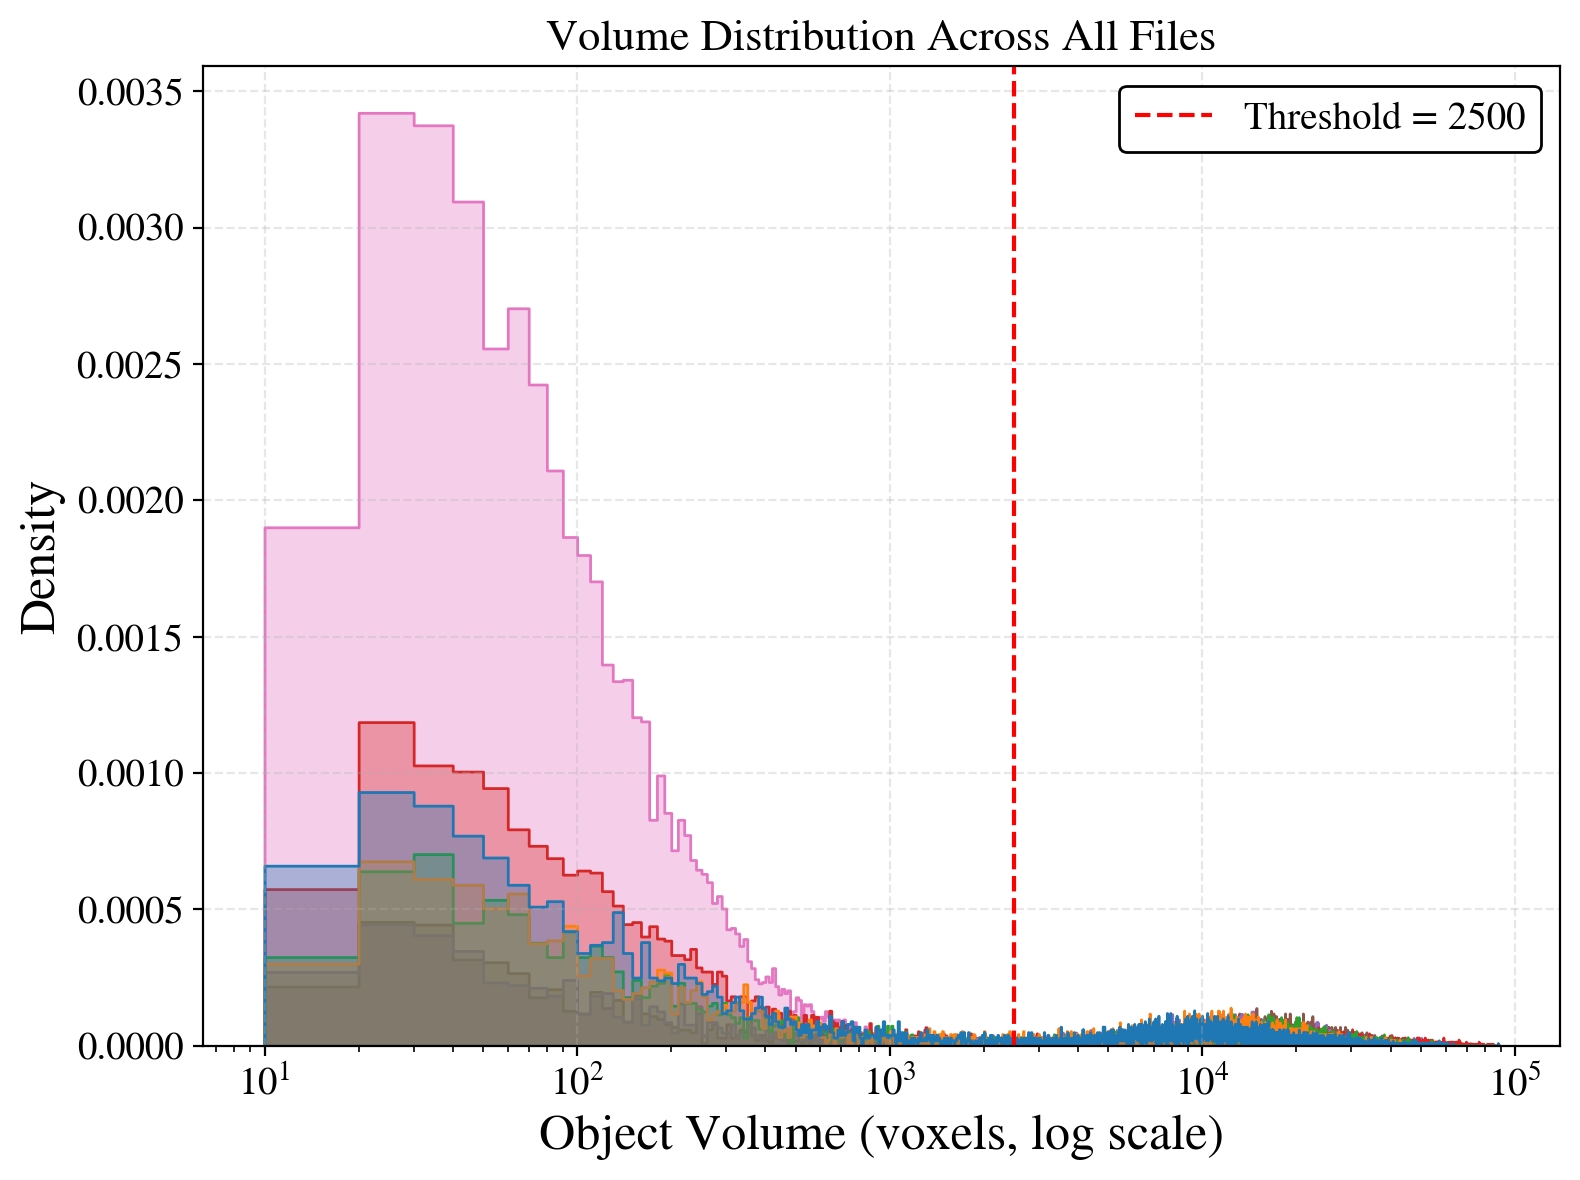

In [35]:
all_volume_distributions = {}

for file_seq in tqdm(ioi_masks, desc='files', total=len(ioi_masks)):
    mask_file = ioi_masks[file_seq]  # shape: (T, Z, Y, X)
    volumes = []
    for t in range(mask_file.shape[0]):  # Loop over T
        mask_3d = mask_file[t]           # shape: (Z, Y, X)
        labelled = label(mask_3d) if mask_3d.max() <= 1 else mask_3d
        props = regionprops(labelled)
        volumes.extend([p.area for p in props])  # "area" is volume (voxel count) in 3D
    all_volume_distributions[file_seq] = volumes

volume_list = []
file_list = []

for file_seq, volumes in all_volume_distributions.items():
    file_name = ioi_files_name[file_seq]
    volume_list.extend(volumes)
    file_list.extend([file_name]*len(volumes))

df = pd.DataFrame({'volume': volume_list, 'file': file_list})

plt.figure(figsize=(8, 6), dpi=200)
sns.histplot(
    data=df,
    x='volume',
    hue='file',
    binwidth=10,
    alpha=0.35,
    stat="density",
    element='step',
    common_norm=False
)

plt.xscale('log')
plt.xlabel('Object Volume (voxels, log scale)')
plt.ylabel('Density')
plt.title('Volume Distribution Across All Files')
plt.grid(True, linestyle='--', alpha=0.3)
threshold = 2500
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
MIN_VOLUME = 2500

ioi_filtered_masks = {}

for file in tqdm(ioi_masks, desc="Filtering masks", total=len(ioi_masks)):
    mask_file = ioi_masks[file]  # shape: (T, Z, Y, X)
    filtered_mask = np.zeros_like(mask_file)
    for t in range(mask_file.shape[0]):
        # If the masks are binary, label first
        labelled = label(mask_file[t]) if mask_file[t].max() <= 1 else mask_file[t]
        # Remove small objects from the label image
        cleaned = remove_small_objects(labelled, min_size=MIN_VOLUME)
        filtered_mask[t] = cleaned
    ioi_filtered_masks[file] = filtered_mask

for file in ioi_region:
    df = ioi_region[file]
    df = df[df['volume'] >= MIN_VOLUME].reset_index(drop=True)
    ioi_region[file] = df 

for file in ioi_region:
    print(f"{file}: min volume = {ioi_region[file]['volume'].min()} (n={len(ioi_region[file])})")

Filtering masks:   0%|          | 0/7 [00:00<?, ?it/s]

0: min volume = 2513.0 (n=8032)
1: min volume = 2514.0 (n=7857)
2: min volume = 2561.0 (n=8187)
3: min volume = 2501.0 (n=10088)
4: min volume = 2511.0 (n=9442)
5: min volume = 2521.0 (n=9354)
6: min volume = 2504.0 (n=9220)


# $\Delta.$ Tracking

In [ ]:
feature_list = [
    "volume",            # use "area" if that's your column name
    # "intensity_mean",  # add more if available/useful
]

ioi_tracking = {}

for file_seq in tqdm(ioi_region, desc='File', total=len(ioi_region)):
    df_file = ioi_region[file_seq]
    objects = []
    for _, row in df_file.iterrows():
        obj = PyTrackObject()
        obj.t = int(row['frame'])
        obj.z = float(row.get('z', 0))
        obj.y = float(row['y'])
        obj.x = float(row['x'])
        coords = row['coords']
        if isinstance(coords, np.ndarray):
            coords = coords.tolist()
        obj.properties = {
            "volume": row["volume"],
            "coords": json.dumps(coords),
            "intensity_mean": row.get("intensity_mean", np.nan),
            "intensity_max": row.get("intensity_max", np.nan),
            "intensity_min": row.get("intensity_min", np.nan),
            "intensity_std": row.get("intensity_std", np.nan),
            "major_axis_length": row.get("major_axis_length", np.nan),
            "minor_axis_length": row.get("minor_axis_length", np.nan),
            "solidity": row.get("solidity", np.nan),
            "extent": row.get("extent", np.nan),
        }
        objects.append(obj)

    # --- Setup and run tracker for all objects together ---
    T, Z, Y, X = ioi_masks[file_seq].shape
    with btrack.BayesianTracker() as tracker:
        tracker.configure('/Users/marsian/PhD_LifeSciRes/Image_Python/Cathal_Data/good_2/cell_config.json')  # Update to your config path
        tracker.max_search_radius = 55
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        tracker.features = feature_list
        tracker.append(objects)
        tracker.volume = ((0, X), (0, Y), (0, Z))   # 3D volume!
        tracker.track(step_size=1)
        tracker.optimize(optimizer_options={'tm_lim': int(12e4)})

        # Collect tracks
        tracks = tracker.tracks
        track_data = []
        for track in tracks:
            tdic = track.to_dict()
            for i in range(len(tdic['t'])):
                coords_raw = tdic.get('coords', [None]*len(tdic['t']))[i]
                try:
                    coords = np.array(json.loads(coords_raw)) if coords_raw else np.nan
                except Exception:
                    coords = np.nan
                entry = {
                    'id': tdic['ID'],
                    't': tdic['t'][i],
                    'z': tdic.get('z', [np.nan]*len(tdic['t']))[i],
                    'y': tdic['y'][i],
                    'x': tdic['x'][i],
                    'coords': coords,
                    'volume': tdic.get('volume', [np.nan]*len(tdic['t']))[i],
                    'intensity_mean': tdic.get('intensity_mean', [np.nan]*len(tdic['t']))[i],
                    'intensity_max': tdic.get('intensity_max', [np.nan]*len(tdic['t']))[i],
                    'intensity_min': tdic.get('intensity_min', [np.nan]*len(tdic['t']))[i],
                    'intensity_std': tdic.get('intensity_std', [np.nan]*len(tdic['t']))[i],
                    'major_axis_length': tdic.get('major_axis_length', [np.nan]*len(tdic['t']))[i],
                    'minor_axis_length': tdic.get('minor_axis_length', [np.nan]*len(tdic['t']))[i],
                    'solidity': tdic.get('solidity', [np.nan]*len(tdic['t']))[i],
                    'extent': tdic.get('extent', [np.nan]*len(tdic['t']))[i],
                }
                track_data.append(entry)
        df_t = pd.DataFrame(track_data)
        ioi_tracking[file_seq] = df_t

In [36]:
file_name = "ioi_tracking.pkl" 
file_path = os.path.join(folder_path, file_name) 
os.makedirs(folder_path, exist_ok=True)
with open(file_path, "wb") as file:
    pickle.dump(ioi_tracking, file)
print(f"Dictionary saved successfully to {file_path}")

Dictionary saved successfully to ./ioi_tracking.pkl


In [37]:
file_name = "ioi_tracking.pkl"
file_path = os.path.join(folder_path, file_name)
with open(file_path, "rb") as file:
    ioi_tracking = pickle.load(file)

print("Dictionary loaded successfully!")

Dictionary loaded successfully!


In [40]:
output_dir = "tracking_csvs"
os.makedirs(output_dir, exist_ok=True)

for key, df in ioi_tracking.items():
    # Use ioi_files_name for better file naming, fallback to key if not found
    base_name = str(ioi_files_name[key]) if key in ioi_files_name else f"File_{key}"
    # Clean filename: remove extension, bad characters, spaces, etc.
    safe_name = os.path.splitext(base_name)[0].replace(' ', '_').replace('/', '_').replace('\\', '_')
    csv_path = os.path.join(output_dir, f"{safe_name}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved {csv_path}")

print(f"All CSVs exported to {os.path.abspath(output_dir)}")

Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep3_laser=2_FOV1.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep3_laser=2_FOV2.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep3_laser=2_FOV3.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep4_laser=2_FOV1.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep4_laser=2_FOV2.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep4_laser=2_FOV3.csv
Saved tracking_csvs/20250721_THP1_+CoC_z_step=0.5_1min_x_15min_Rep4_laser=2_FOV4.csv
All CSVs exported to /Users/marsian/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Basu_Lab/Tingyun_4_imaging/tracking_csvs


In [41]:
# --- Napari-compatible tracks (for 3D) ---
ioi_napari_tracks = {}
for file_seq, df in ioi_tracking.items():
    if "z" in df.columns:
        track_array = df[['id', 't', 'z', 'y', 'x']].to_numpy()
    else:
        track_array = df[['id', 't', 'y', 'x']].to_numpy()
    ioi_napari_tracks[file_seq] = track_array

In [39]:
file = 0
viewer = napari.Viewer()
viewer.add_image(
    ioi_files[file],
    name='raw',
    colormap='I Blue',
    blending='minimum'
    )
viewer.add_image(
    ioi_filtered_masks[file],
    name='seg',
    blending='additive',
    colormap='gist_earth'
    )
viewer.add_tracks(
    ioi_napari_tracks[file],
    name="Tracks_TUDR", 
    blending="translucent",
    visible=True,
    colormap='gist_earth', 
    tail_length=8
)

<Tracks layer 'Tracks_TUDR' at 0xcb5b06ad0>

In [42]:
min_track_length = 10

ioi_tracking_filtered = {}

for file_seq, df in ioi_tracking.items():
    # Count frame occurrences for each id
    id_counts = df['id'].value_counts()
    keep_ids = id_counts[id_counts >= min_track_length].index
    # Filter dataframe
    df_filtered = df[df['id'].isin(keep_ids)].copy()
    ioi_tracking_filtered[file_seq] = df_filtered

    print(f"File {file_seq}: {len(id_counts)} total tracks, {len(keep_ids)} tracks >= {min_track_length} frames.")

# If you also want to update napari_tracks:
ioi_napari_tracks_filtered = {}
for file_seq, df in ioi_tracking_filtered.items():
    if "z" in df.columns:
        track_array = df[['id', 't', 'z', 'y', 'x']].to_numpy()
    else:
        track_array = df[['id', 't', 'y', 'x']].to_numpy()
    ioi_napari_tracks_filtered[file_seq] = track_array

File 0: 661 total tracks, 475 tracks >= 10 frames.
File 1: 667 total tracks, 458 tracks >= 10 frames.
File 2: 704 total tracks, 482 tracks >= 10 frames.
File 3: 1060 total tracks, 571 tracks >= 10 frames.
File 4: 807 total tracks, 560 tracks >= 10 frames.
File 5: 730 total tracks, 559 tracks >= 10 frames.
File 6: 699 total tracks, 545 tracks >= 10 frames.


In [42]:
file = 0
viewer = napari.Viewer()
viewer.add_image(
    ioi_files[file],
    name='raw',
    colormap='I Blue',
    blending='minimum'
    )
viewer.add_image(
    ioi_filtered_masks[file],
    name='seg',
    blending='additive',
    colormap='gist_earth'
    )
viewer.add_tracks(
    ioi_napari_tracks_filtered[file],
    name="Tracks_TUDR", 
    blending="translucent",
    visible=True,
    colormap='gist_earth', 
    tail_length=8
)

<Tracks layer 'Tracks_TUDR' at 0xcb5b5de10>

In [ ]:
# --- Calibration: set your pixel and time units here ---
pixel_size_xy = 332.8 / 1024        # micrometers per pixel (xy-plane)
pixel_size_z  = 1.72 * pixel_size_xy     # micrometers per pixel (z-step)
frame_interval_sec = 60  # seconds per frame

# --- Required imports ---
import numpy as np
import pandas as pd
import json
from joblib import Parallel, delayed
from skimage.measure import marching_cubes
from tqdm.notebook import tqdm

# --- Function to add speed and turning angle to tracks (in microns) ---
def add_speed_and_angle(
    df, 
    pixel_size_xy_um=pixel_size_xy, 
    pixel_size_z_um=pixel_size_z, 
    frame_interval_sec=frame_interval_sec):
    df = df.sort_values(['id', 't']).copy()
    df['inst_speed_um_s'] = np.nan
    df['turning_angle_rad'] = np.nan

    for track_id, group in df.groupby('id'):
        group = group.sort_values('t')
        N = len(group)
        dx = group['x'].diff().values * pixel_size_xy_um
        dy = group['y'].diff().values * pixel_size_xy_um
        dz = group['z'].diff().values * pixel_size_z_um if 'z' in group.columns else np.zeros_like(dx)
        dist_um = np.sqrt(dx**2 + dy**2 + dz**2)
        speed = dist_um / frame_interval_sec
        df.loc[group.index, 'inst_speed_um_s'] = speed

        turning_angles = np.full(N, np.nan)
        if N >= 3:
            v_prev = np.stack([dx[:-2], dy[:-2], dz[:-2]], axis=1)
            v_next = np.stack([dx[1:-1], dy[1:-1], dz[1:-1]], axis=1)
            dot = np.einsum('ij,ij->i', v_prev, v_next)
            norm_prod = np.linalg.norm(v_prev, axis=1) * np.linalg.norm(v_next, axis=1)
            with np.errstate(invalid='ignore'):
                cos_theta = dot / norm_prod
                cos_theta = np.clip(cos_theta, -1, 1)
                angles = np.arccos(cos_theta)
            turning_angles[1:-1] = angles
        df.loc[group.index, 'turning_angle_rad'] = turning_angles
    return df

# --- Function to compute surface area using marching cubes (microns) ---
def fast_compute_surface_area(coords, mask_shape, pixel_size_xy, pixel_size_z):
    obj_mask = np.zeros(mask_shape, dtype=bool)
    coords = np.array(coords)
    if coords.ndim == 2 and coords.shape[1] == 3:
        obj_mask[coords[:,0], coords[:,1], coords[:,2]] = 1
    else:
        return np.nan
    if np.count_nonzero(obj_mask) < 5:
        return np.nan
    padded = np.pad(obj_mask, 1)
    verts, faces, _, _ = marching_cubes(padded, level=0.5)
    verts[:, 0] *= pixel_size_z    # scale z to microns
    verts[:, 1] *= pixel_size_xy   # scale y to microns
    verts[:, 2] *= pixel_size_xy   # scale x to microns
    area = 0.0
    for tri in faces:
        pts = verts[tri]
        a, b, c = pts[0], pts[1], pts[2]
        area += np.linalg.norm(np.cross(b - a, c - a)) / 2
    return area

def sphericity_worker(row, mask_shape, pixel_size_xy, pixel_size_z):
    coords = row['coords']
    if isinstance(coords, str):
        coords = json.loads(coords)
    if coords is None or len(coords) < 5:
        return np.nan
    area = fast_compute_surface_area(coords, mask_shape, pixel_size_xy, pixel_size_z)
    # Convert volume from voxels to μm³
    V_um3 = row['volume'] * pixel_size_xy * pixel_size_xy * pixel_size_z
    if area > 0 and V_um3 > 0:
        sph = (np.pi ** (1/3)) * (6 * V_um3) ** (2/3) / area
    else:
        sph = np.nan
    return sph

def add_sphericity_parallel(df, mask_shape, pixel_size_xy, pixel_size_z, n_jobs=-1):
    sphericities = Parallel(n_jobs=n_jobs)(
        delayed(sphericity_worker)(row, mask_shape, pixel_size_xy, pixel_size_z)
        for _, row in df.iterrows()
    )
    df = df.copy()
    df['sphericity'] = sphericities
    return df

# --- Apply speed, angle, sphericity calculations ---
for file_seq in tqdm(ioi_tracking_filtered):
    ioi_tracking_filtered[file_seq] = add_speed_and_angle(
        ioi_tracking_filtered[file_seq],
        pixel_size_xy_um=pixel_size_xy,
        pixel_size_z_um=pixel_size_z,
        frame_interval_sec=frame_interval_sec,
    )
    mask_shape = ioi_masks[file_seq].shape[1:]
    ioi_tracking_filtered[file_seq] = add_sphericity_parallel(
        ioi_tracking_filtered[file_seq],
        mask_shape=mask_shape,
        pixel_size_xy=pixel_size_xy,
        pixel_size_z=pixel_size_z,
        n_jobs=-1  # Use all CPUs for speed
    )

print("Done. Sphericity and motility metrics added to all filtered tracking tables.")




  0%|          | 0/7 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/imaging/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Done. Sphericity and motility metrics added to all filtered tracking tables.


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_2390/2987602340.py:134: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_2390/2987602340.py:134: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_2390/2987602340.py:134: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

Statistics DataFrame ready! Columns: Index(['id', 'n_frames', 'total_distance_um', 'mean_sphericity',
       'std_sphericity', 'mean_volume_voxel', 'std_volume_voxel', 'file',
       'unique_id', 'mean_volume_um3', 'std_volume_um3'],
      dtype='object')
   id  n_frames  total_distance_um  mean_sphericity  std_sphericity  \
0   2      14.0          14.429765         0.850153        0.017089   
1   4      15.0          23.519260         0.802715        0.034227   
2   5      15.0          11.162136         0.797656        0.009823   
3   6      15.0          28.500360         0.820158        0.010572   
4   7      15.0          23.626726         0.729955        0.024613   

   mean_volume_voxel  std_volume_voxel  file unique_id  mean_volume_um3  \
0        8960.428571        878.424176     0       0_2       529.062905   
1       28410.266667       3567.024820     0       0_4      1677.466439   
2       15541.400000        845.446864     0       0_5       917.632250   
3       27084.800

In [50]:
import os
import pandas as pd

# --- Define output file name and path ---
output_excel_path = "ioi_tracking_filtered_with_sphericity.xlsx"

# --- Save all filtered DataFrames to one Excel file, one sheet per DataFrame ---
with pd.ExcelWriter(output_excel_path) as writer:
    for key, df in ioi_tracking_filtered.items():
        # Sheet name from file name if available, else just the key
        try:
            base_name = ioi_files_name[key]
            sheet_name = os.path.splitext(base_name)[0][:31].replace('/', '_').replace('\\', '_')
        except Exception:
            sheet_name = str(key)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All filtered tracking results with sphericity saved to: {output_excel_path}")

All filtered tracking results with sphericity saved to: ioi_tracking_filtered_with_sphericity.xlsx


In [4]:
import pandas as pd

# Path to your Excel file
excel_path = "ioi_tracking_filtered_with_sphericity.xlsx"

# Read all sheets into a dictionary of DataFrames
ioi_tracking_filtered_loaded = pd.read_excel(excel_path, sheet_name=None)

# Now you have:
# ioi_tracking_filtered_loaded is a dict: {sheet_name: DataFrame, ...}

# If you want to use integer keys again (assuming your sheets are like "0", "1", ...)
ioi_tracking_filtered = {}
for k, v in ioi_tracking_filtered_loaded.items():
    try:
        key = int(k)
    except Exception:
        key = k  # fallback to string
    ioi_tracking_filtered[key] = v

# Usage:
# ioi_tracking_filtered_loaded_int[0]  # This gives you the DataFrame for file 0

In [15]:
print(ioi_tracking_filtered[0].columns)
print(ioi_masks[0].shape[1:])

Index(['id', 't', 'z', 'y', 'x', 'coords', 'volume', 'intensity_mean',
       'intensity_max', 'intensity_min', 'intensity_std', 'major_axis_length',
       'minor_axis_length', 'solidity', 'extent', 'inst_speed_um_s',
       'turning_angle_rad'],
      dtype='object')
(38, 1024, 1024)


In [9]:
# --- Calibration: set your pixel and time units here ---
pixel_size_xy = 332.8 / 1024        # micrometers per pixel (xy-plane)
pixel_size_z  = 1.72 * pixel_size_xy     # micrometers per pixel (z-step)
frame_interval_sec = 60  # seconds per frame

# --- Efficient per-track statistics function ---
def calc_track_stats(track, px_xy, px_z):
    arr = track.sort_values('t')[['x','y','z']].values
    arr[:,0] *= px_xy
    arr[:,1] *= px_xy
    arr[:,2] *= px_z
    dists = np.sqrt(np.sum(np.diff(arr, axis=0)**2, axis=1))
    return pd.Series({
        'n_frames': len(track),
        'total_distance_um': dists.sum(),
        'mean_sphericity': track['sphericity'].mean(),
        'std_sphericity': track['sphericity'].std(),
        'mean_volume_voxel': track['volume'].mean(),
        'std_volume_voxel': track['volume'].std()
    })

# --- Build the ioi_statistics dataframe using fast groupby/apply ---
statistics_list = []
for file_seq, df in ioi_tracking_filtered.items():
    stats = (
        df.groupby('id', group_keys=False)
          .apply(calc_track_stats, pixel_size_xy, pixel_size_z)
          .reset_index()
    )
    stats['file'] = file_seq
    stats['unique_id'] = stats['file'].astype(str) + '_' + stats['id'].astype(str)
    statistics_list.append(stats)
ioi_statistics = pd.concat(statistics_list, ignore_index=True)

# --- Convert all volume stats from voxels to μm³ ---
voxel_um3 = pixel_size_xy * pixel_size_xy * pixel_size_z
ioi_statistics['mean_volume_um3'] = ioi_statistics['mean_volume_voxel'] * voxel_um3
ioi_statistics['std_volume_um3']  = ioi_statistics['std_volume_voxel']  * voxel_um3

print("Statistics DataFrame ready! Columns:", ioi_statistics.columns)
print(ioi_statistics.head())
output_csv = "ioi_statistics.csv"
ioi_statistics.to_csv(output_csv, index=False)
print(f"Saved statistics to: {output_csv}")

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_1470/340172437.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_track_stats, pixel_size_xy, pixel_size_z)


Statistics DataFrame ready! Columns: Index(['id', 'n_frames', 'total_distance_um', 'mean_sphericity',
       'std_sphericity', 'mean_volume_voxel', 'std_volume_voxel', 'file',
       'unique_id', 'mean_volume_um3', 'std_volume_um3'],
      dtype='object')
   id  n_frames  total_distance_um  mean_sphericity  std_sphericity  \
0   1      15.0          17.509715         0.791005        0.028288   
1   2      15.0          12.456733         0.790588        0.019395   
2   3      15.0          13.765379         0.746356        0.032323   
3   5      15.0          16.672617         0.745496        0.032595   
4   6      15.0          18.353869         0.833609        0.020431   

   mean_volume_voxel  std_volume_voxel                             file  \
0       13790.200000       3477.480270  20250721 THP1 +CoC z step=0.5 1   
1       20286.000000       1703.451832  20250721 THP1 +CoC z step=0.5 1   
2        8951.600000       1758.474168  20250721 THP1 +CoC z step=0.5 1   
3       25282.800

In [53]:
import plotly.graph_objs as go

fig = go.Figure(data=[go.Scatter3d(
    x=ioi_statistics['total_distance_um'],
    y=ioi_statistics['mean_sphericity'],
    z=ioi_statistics['mean_volume_um3'],
    mode='markers',
    marker=dict(
        size=2,
        color=ioi_statistics['file'],   # Color by file index
        colorscale='Blues',
        opacity=0.8,
        line=dict(width=1, color='black')
    ),
    text=ioi_statistics['unique_id'],   # hover text
    hovertemplate=(
        'File: %{marker.color}<br>'
        'Unique ID: %{text}<br>'
        'Total Distance: %{x:.1f} μm<br>'
        'Mean Sphericity: %{y:.3f}<br>'
        'Mean Volume: %{z:.0f} μm³'
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Total Distance Travelled (μm)',
        yaxis_title='Mean Sphericity',
        zaxis_title='Mean Volume (μm³)'
    ),
    title='Cell Tracks: Distance vs. Sphericity vs. Volume',
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title='File'
)

fig.show()

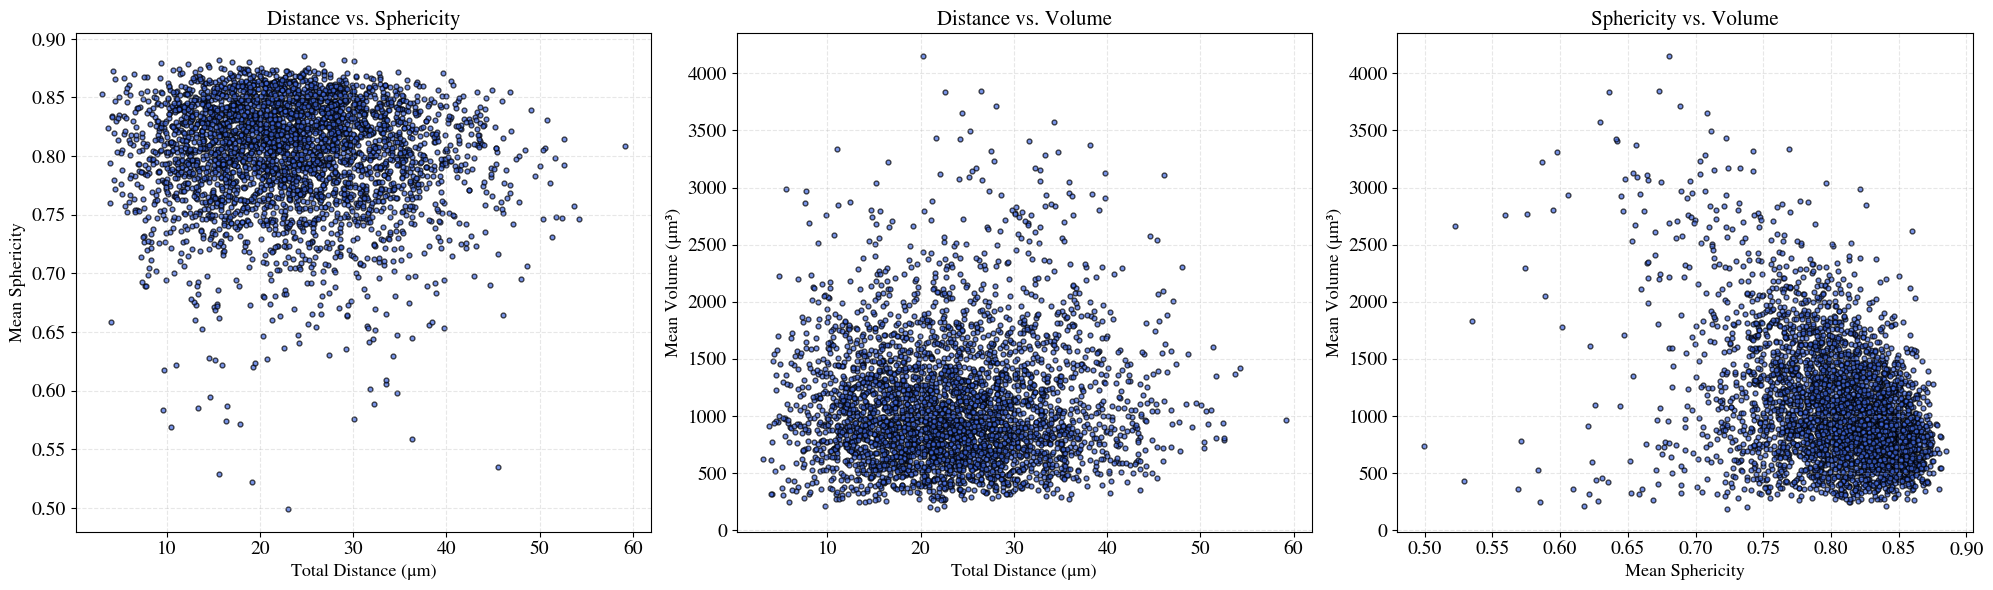

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Total distance vs. Mean sphericity
axes[0].scatter(
    ioi_statistics['total_distance_um'],
    ioi_statistics['mean_sphericity'],
    c='royalblue', alpha=0.7, edgecolor='k', s=12
)
axes[0].set_xlabel('Total Distance (μm)', fontsize=13)
axes[0].set_ylabel('Mean Sphericity', fontsize=13)
axes[0].set_title('Distance vs. Sphericity', fontsize=15)
axes[0].grid(True, linestyle="--", alpha=0.3)

# Plot 2: Total distance vs. Mean volume
axes[1].scatter(
    ioi_statistics['total_distance_um'],
    ioi_statistics['mean_volume_um3'],
    c='royalblue', alpha=0.7, edgecolor='k', s=12
)
axes[1].set_xlabel('Total Distance (μm)', fontsize=13)
axes[1].set_ylabel('Mean Volume (μm³)', fontsize=13)
axes[1].set_title('Distance vs. Volume', fontsize=15)
axes[1].grid(True, linestyle="--", alpha=0.3)

# Plot 3: Mean sphericity vs. Mean volume
axes[2].scatter(
    ioi_statistics['mean_sphericity'],
    ioi_statistics['mean_volume_um3'],
    c='royalblue', alpha=0.7, edgecolor='k', s=12
)
axes[2].set_xlabel('Mean Sphericity', fontsize=13)
axes[2].set_ylabel('Mean Volume (μm³)', fontsize=13)
axes[2].set_title('Sphericity vs. Volume', fontsize=15)
axes[2].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

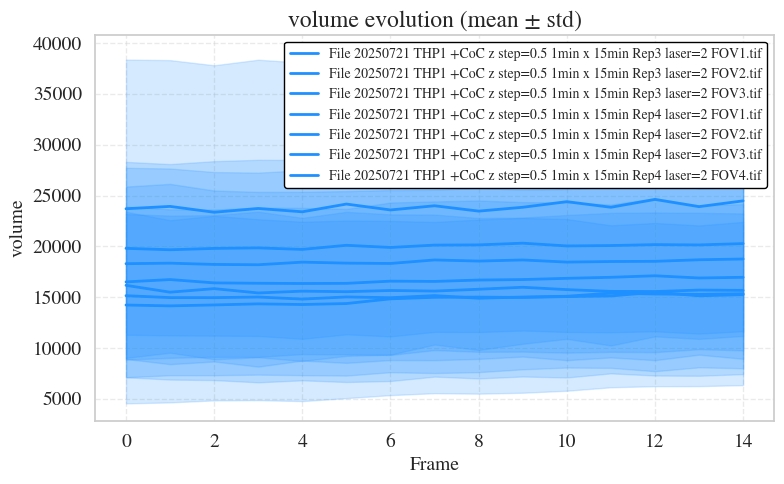

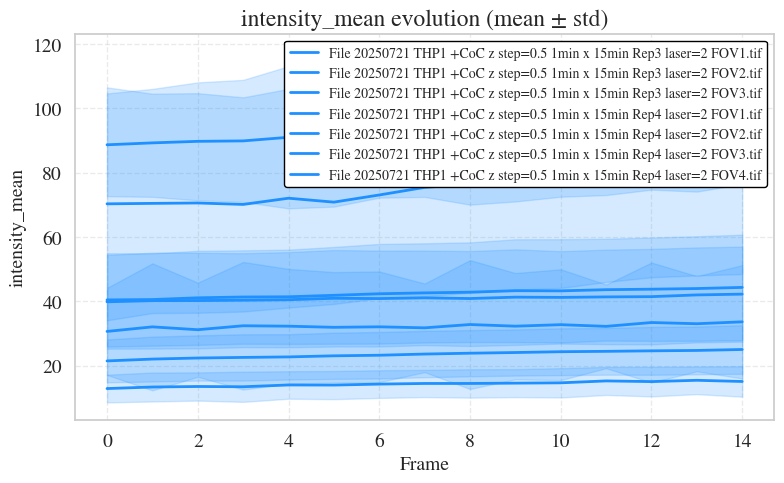

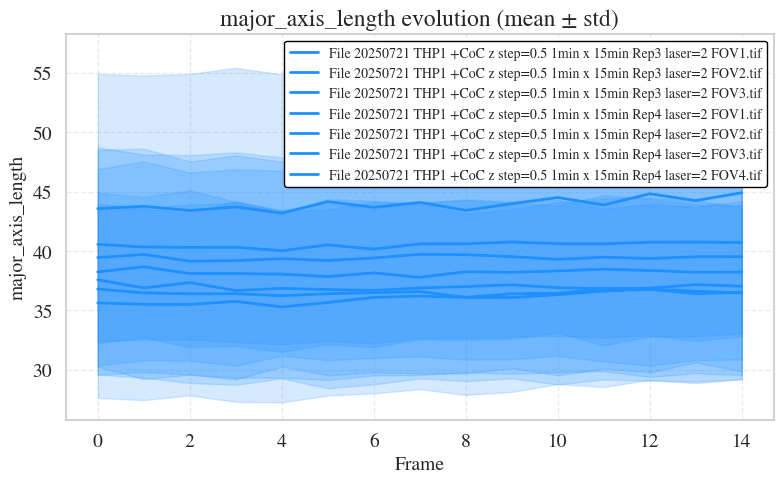

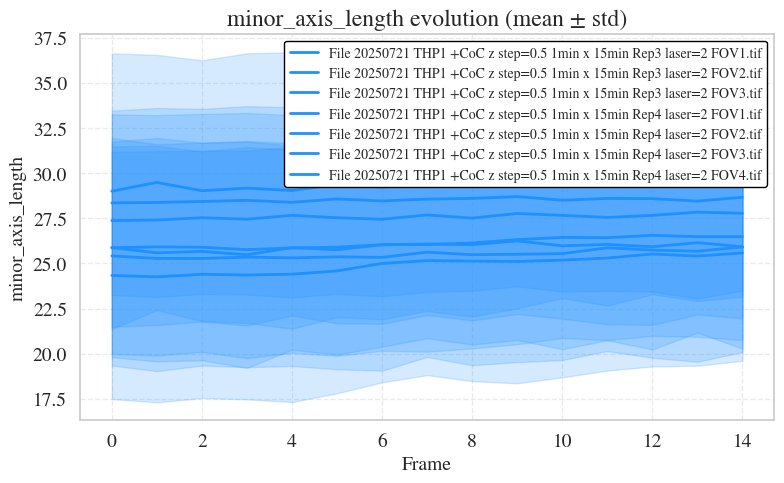

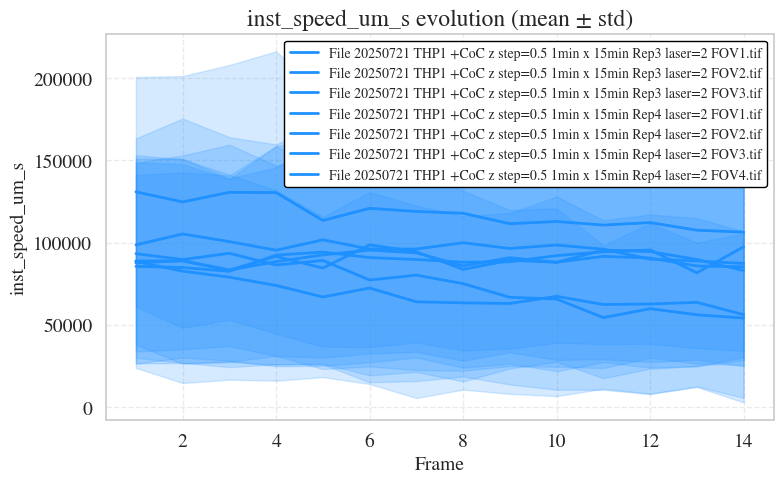

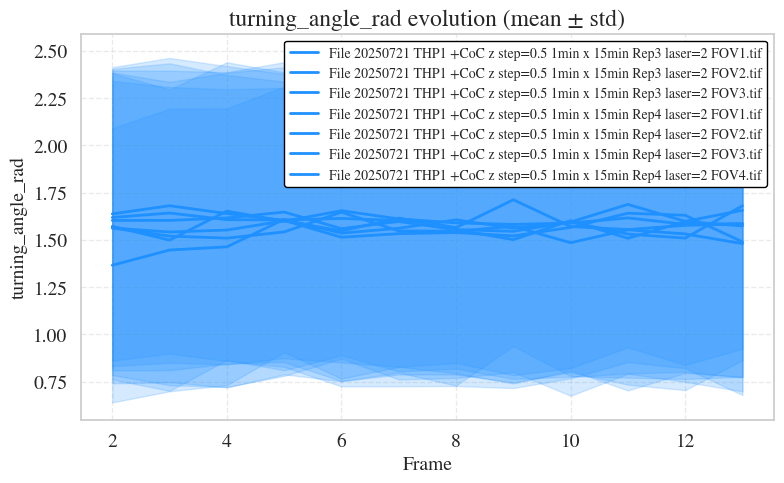

In [51]:
feature_cols = [
    'volume',
    'intensity_mean',
    # 'intensity_max',
    # 'intensity_min',
    # 'intensity_std',
    'major_axis_length',
    'minor_axis_length',
    'inst_speed_um_s',
    'turning_angle_rad',
    # 'solidity',
    # 'extent'
]

for feature in feature_cols:
    plt.figure(figsize=(8, 5))
    for file_idx, (file_seq, df) in enumerate(ioi_tracking_filtered.items()):
        if feature not in df.columns:
            continue
        mean_vals = df.groupby('t')[feature].mean()
        std_vals = df.groupby('t')[feature].std()
        t = mean_vals.index
        plt.plot(
            t, mean_vals,
            label=f"File {ioi_files_name[file_idx]}",
            color="dodgerblue", lw=2
        )
        plt.fill_between(
            t, mean_vals - std_vals, mean_vals + std_vals,
            alpha=0.18, color="dodgerblue"
        )
    plt.title(f"{feature} evolution (mean ± std)", fontsize=17)
    plt.xlabel("Frame", fontsize=14)
    plt.ylabel(feature, fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

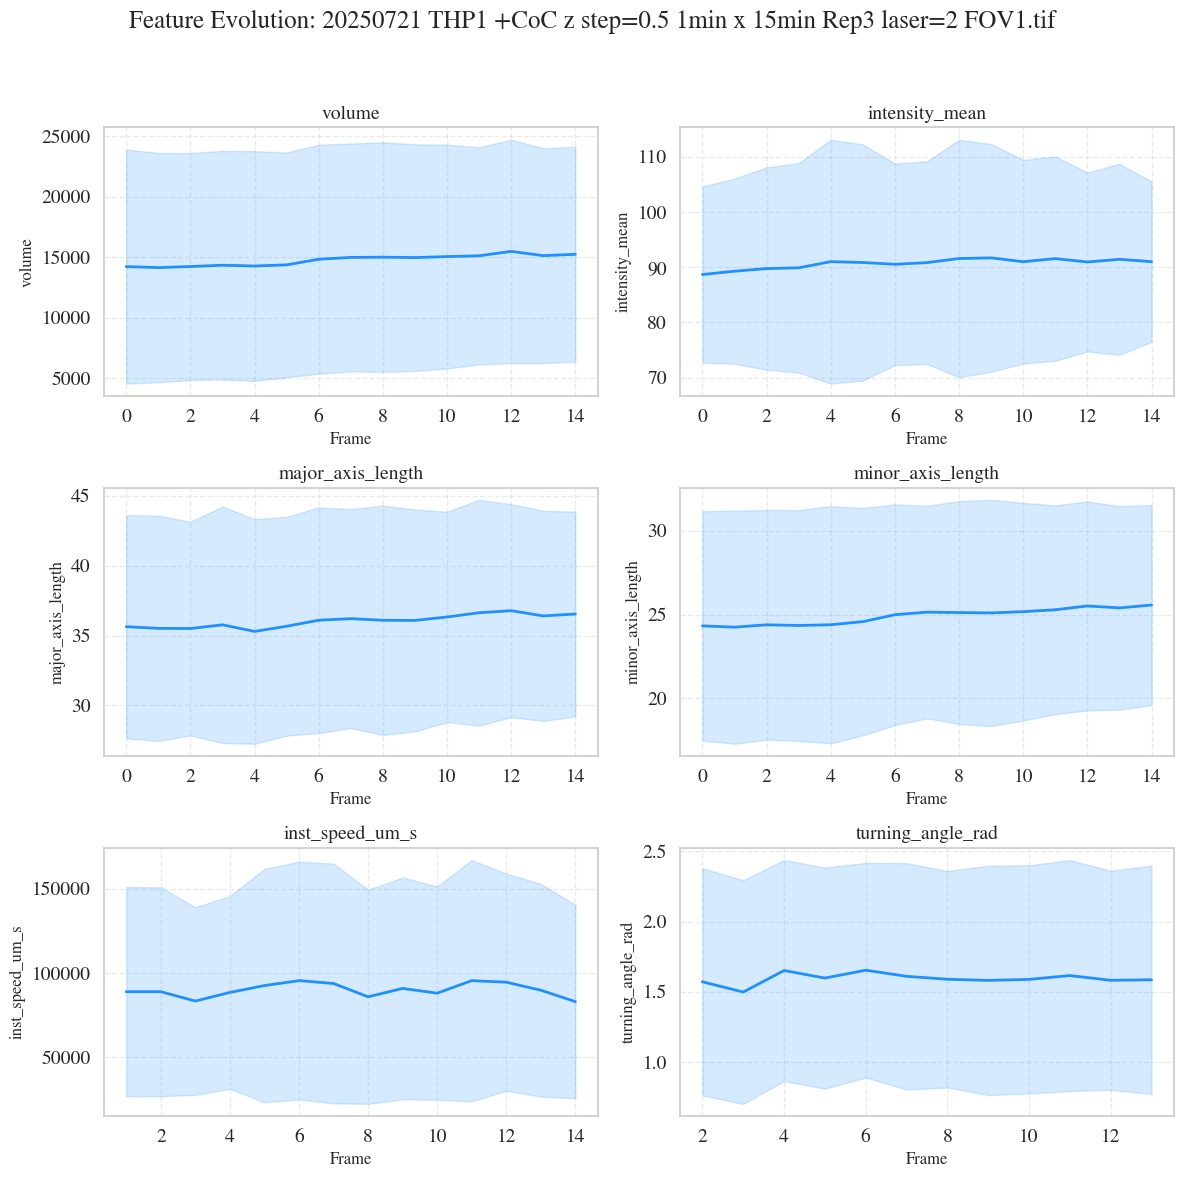

In [52]:
def plot_metrics_evolution(tracking_dict, file_key, feature_cols, file_label=""):
    """
    Plots the time evolution (mean ± std) of each metric in one figure (multiple subplots)
    for a given file in your tracking dictionary.
    
    Parameters:
        tracking_dict: dict of DataFrames {file_key: df}
        file_key:      key of the file to plot (index or string)
        feature_cols:  list of feature names to plot
        file_label:    optional label for the legend/title
    """
    df = tracking_dict[file_key]
    n_feat = len(feature_cols)
    ncols = 2
    nrows = int(np.ceil(n_feat / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        if feature not in df.columns:
            ax.set_axis_off()
            continue
        mean_vals = df.groupby('t')[feature].mean()
        std_vals = df.groupby('t')[feature].std()
        t = mean_vals.index

        ax.plot(t, mean_vals, color='dodgerblue', lw=2, label=file_label)
        ax.fill_between(t, mean_vals - std_vals, mean_vals + std_vals, color='dodgerblue', alpha=0.18)
        ax.set_title(f"{feature}", fontsize=14)
        ax.set_xlabel("Frame", fontsize=12)
        ax.set_ylabel(feature, fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.4)

    # Remove unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_axis_off()

    plt.suptitle(f"Feature Evolution: {file_label or file_key}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
feature_cols = [
    'volume',
    'intensity_mean',
    # 'intensity_max',
    # 'intensity_min',
    # 'intensity_std',
    'major_axis_length',
    'minor_axis_length',
    'inst_speed_um_s',
    'turning_angle_rad',
    # 'solidity',
    # 'extent'
]
plot_metrics_evolution(ioi_tracking_filtered, file_key=0, feature_cols=feature_cols, file_label=ioi_files_name[0])


In [23]:
def show_tracks_with_segmentation(file_idx):
    # Load
    image = ioi_files[file_idx]      # shape: (T, Z, Y, X) or (T, Y, X)
    seg = ioi_masks[file_idx]        # integer mask, shape: (T, Z, Y, X) or (T, Y, X)
    df = ioi_tracking[file_idx]      # DataFrame: must have 't', 'id', 'coords'
    tracks = ioi_napari_tracks[file_idx]  # shape: (N, 5) or (N, 4) for napari
    
    # --- Build segmentation labelled by track ID ---
    # Copy seg mask so we don't overwrite original
    seg_trackid = np.zeros_like(seg, dtype=np.int32)
    
    for row in df.itertuples(index=False):
        t = int(row.t)
        track_id = int(row.id)
        coords = np.array(row.coords)
        if coords.size == 0 or track_id == 0:
            continue
        coords = coords.astype(int)
        # 3D: (z, y, x), 2D: (y, x)
        if coords.ndim != 2:
            continue
        if coords.shape[1] == 3:  # (z, y, x)
            seg_trackid[(t, coords[:, 0], coords[:, 1], coords[:, 2])] = track_id
        elif coords.shape[1] == 2:  # (y, x)
            seg_trackid[(t, coords[:, 0], coords[:, 1])] = track_id
        else:
            continue  # skip
        
    # --- Launch napari and add layers ---
    viewer = napari.Viewer()
    viewer.add_image(
        image,
        name='Raw Image',
        blending='minimum',
        colormap='gray'
    )
    viewer.add_labels(
        seg_trackid,
        name='Segmentation (track ID labels)'
    )
    viewer.add_tracks(
        tracks,
        name='Tracks',
        blending="translucent",
        tail_length=8
    )
    print("Use napari to browse and check overlays! Close the napari window to continue.")
    return viewer

# Usage:
show_tracks_with_segmentation(file_idx=2)

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_58084/1753456642.py:18: RuntimeWarning: invalid value encountered in cast
  coords = coords.astype(int)


Use napari to browse and check overlays! Close the napari window to continue.


Viewer(camera=Camera(center=(0.0, 511.5, 511.5), zoom=0.7783691406250001, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(7.0, 19.0, 0.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=4, ndisplay=2, order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3'), rollable=(True, True, True, True), range=(RangeTuple(start=0.0, stop=15.0, step=1.0), RangeTuple(start=0.0, stop=38.0, step=1.0), RangeTuple(start=0.0, stop=1023.0, step=1.0), RangeTuple(start=0.0, stop=1023.0, step=1.0)), margin_left=(0.0, 0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0, 0.0), point=(7.0, 19.0, 511.0, 511.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Raw Image' at 0xaad59aa90>, <Labels layer 'Segmentation (track ID labels)' at 0xaa2456550>, <Tracks layer 'Tracks' at 0xa862e0d10>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', t